# A practical introduction to image classification
In this notebook, we introduce image classification on a difficult dataset.
## The CIFAR dataset

You can download the data from here: https://www.cs.toronto.edu/~kriz/cifar.html

In particular, we are using the CIFAR-10 dataset in the Python version:
https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz (About 160 MB)

Untar the file in a directory named "cifar-10" placed in the current working directory

In [20]:
import numpy as np
import pickle
import pathlib

from sklearn.neighbors import KNeighborsClassifier

ddir = pathlib.Path("cifar-10")
print(f"We expect the data files in directory {ddir.absolute()}")

We expect the data files in directory /Users/davebrunner/Documents/repositories/TSM_CompVis/05_week/cifar-10


In [21]:
with open(ddir / "batches.meta", 'rb') as fo:
    labelnames = pickle.load(fo)["label_names"]

data_tr = []
labels_tr = []
for i in range(1, 6):
    with open(ddir / "data_batch_{}".format(i), 'rb') as fo:
        alldata = pickle.load(fo, encoding='bytes')
    data_tr.append(alldata[b"data"])
    labels_tr.append(np.array(alldata[b"labels"]))
data_tr = np.vstack(data_tr)
labels_tr = np.hstack(labels_tr)

with open(ddir / "test_batch", 'rb') as fo:
    alldata = pickle.load(fo, encoding='bytes')
data_te = alldata[b"data"]
labels_te = np.array(alldata[b"labels"])

# %% We now have two datasets, one for training and one for testing

print("Training data and labels with shapes: ", data_tr.shape, labels_tr.shape)
print("Testing data and labels with shapes: ", data_te.shape, labels_te.shape)
print("Meaning of the label codes: ", list(enumerate(labelnames)))

Training data and labels with shapes:  (50000, 3072) (50000,)
Testing data and labels with shapes:  (10000, 3072) (10000,)
Meaning of the label codes:  [(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]


In [22]:
import pandas as pd

pd.Series(labels_tr).value_counts()

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

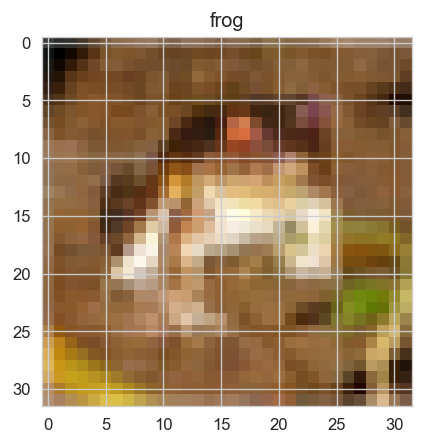

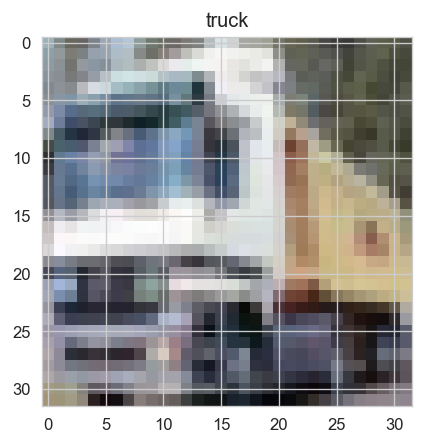

In [23]:
# %% Support function for drawing an image
import matplotlib.pyplot as plt
%matplotlib inline

def vec2im(imvector):
    """ Convert a vector to an image """
    im = np.reshape(imvector, (3, 32, 32))  # reshape
    # we want channels to be the last dimension, not the first.
    im = np.transpose(im, axes=(1, 2, 0))
    return im


def showim(im, l=None):
    """ Displays the image im (1D vector with 3072 elements)
    in the currently active axes, and set the title to the name
    corresponding to label l (if given)"""
    plt.imshow(im)
    if l is not None:
        plt.title(labelnames[l])


# %% Let's visualize some of our training images
for i in range(2):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
    showim(vec2im(data_tr[i]), labels_tr[i])
    plt.show()

## Exercise 1: implement a nearest-neighbor classifier approach in pixel space
Given a testing image, we want to look for the training image that is _closest_ when comparing the raw pixel values.
Remember that an image in our dataset is actually a 1D array with 3072 uint8 elements (i.e. 32x32x3 pixels, arranged in a line).

### 1.1: define a function that given two images, computes the euclidean distance between them
Each image is a point in 3072 dimensions.  You can use [`np.linalg.norm(...)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) to find the length of a 3072-dimensional vector...

Remember that you should cast both vectors to `float` before subtracting them.  Use [`ndarray.astype(float)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html)

Eucledian distance between two points in Euclidean space is the length of the line segment between them.

In [24]:
def distance(imvec1, imvec2):
    """ Returns the euclidean distance between two vectors im1 and im2 """
    imvec1 = imvec1.astype(float)
    imvec2 = imvec2.astype(float)

    return np.linalg.norm(imvec1 - imvec2)


print("Should be 1:", distance(np.array([0, 0]), np.array([0, 1])))
print("Should be 5:", distance(np.array([4, 0, 0]), np.array([0, 0, 3])))

Should be 1: 1.0
Should be 5: 5.0


### 1.2: Given a testing image, find the nearest training instance
Then print the true class of the testing instance, and the predicted class (i.e. the class of the closest training instance).

Do this for each of the first 20 testing images. Should take at most 1 second per image.

**Extension**: for each of the first 20 testing images, display it along with its class; besides it display the closest training image, and also the training image that is farthest away (use `fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)`)

Pred is false 
Test image has true label cat and predicted label deer


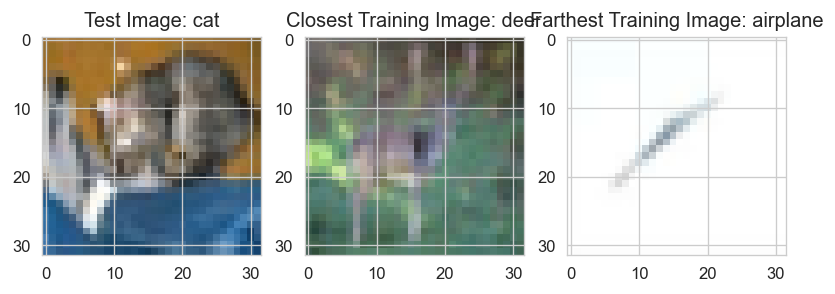

Pred is correct 
Test image has true label ship and predicted label ship


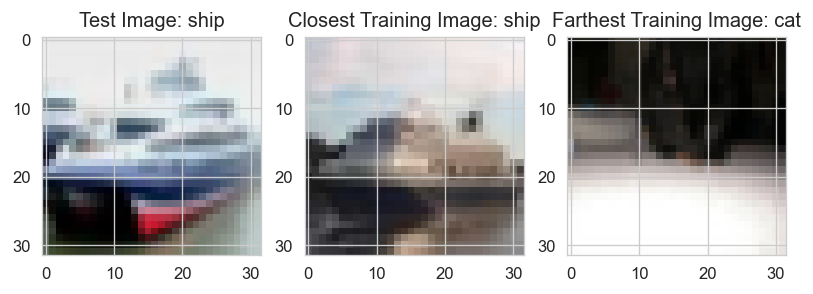

Pred is correct 
Test image has true label ship and predicted label ship


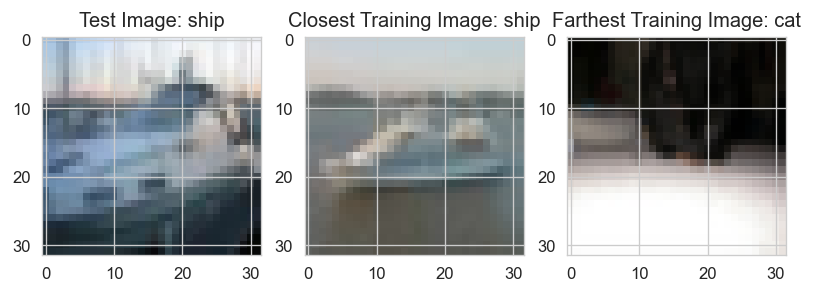

Pred is correct 
Test image has true label airplane and predicted label airplane


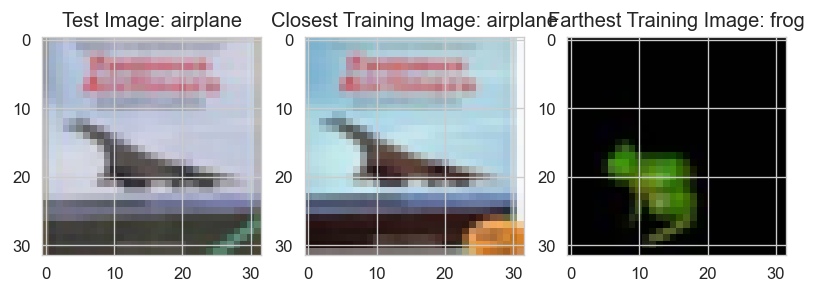

Pred is false 
Test image has true label frog and predicted label deer


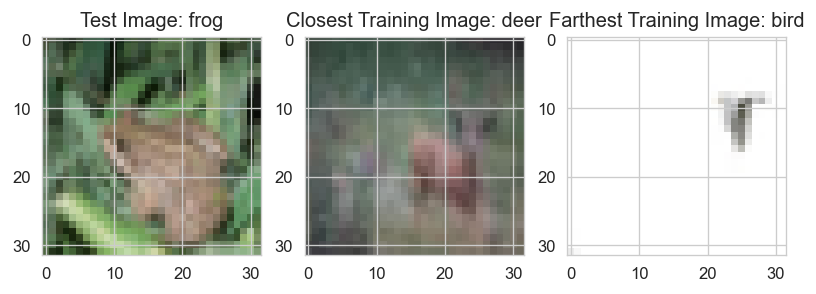

Pred is correct 
Test image has true label frog and predicted label frog


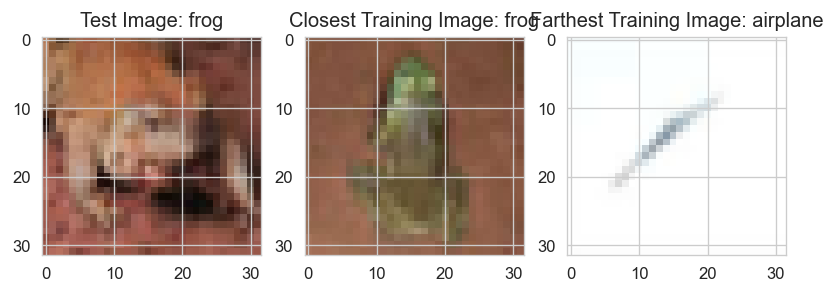

Pred is false 
Test image has true label automobile and predicted label deer


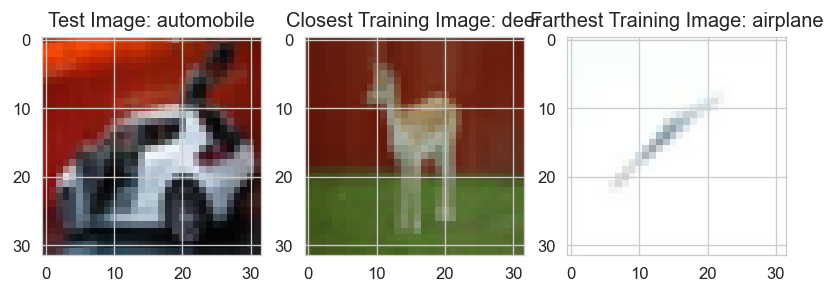

Pred is false 
Test image has true label frog and predicted label bird


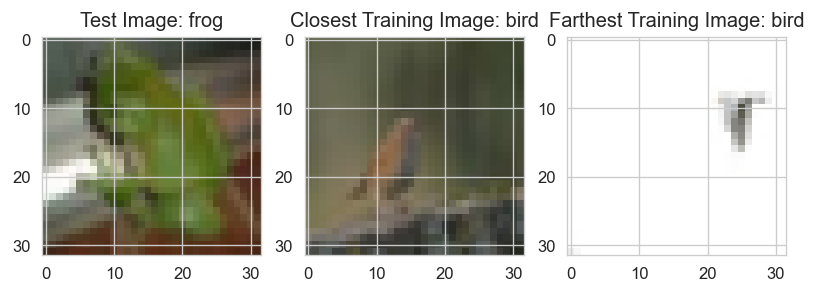

Pred is false 
Test image has true label cat and predicted label deer


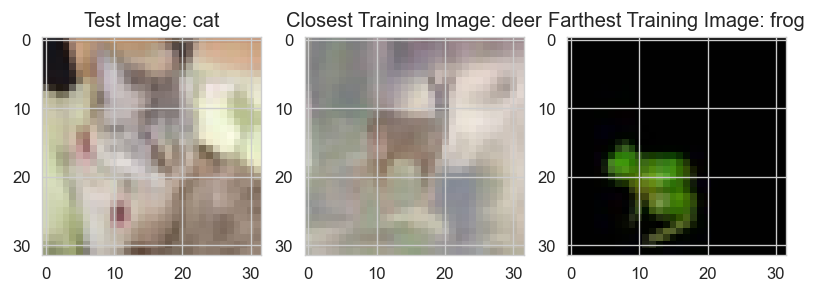

Pred is false 
Test image has true label automobile and predicted label ship


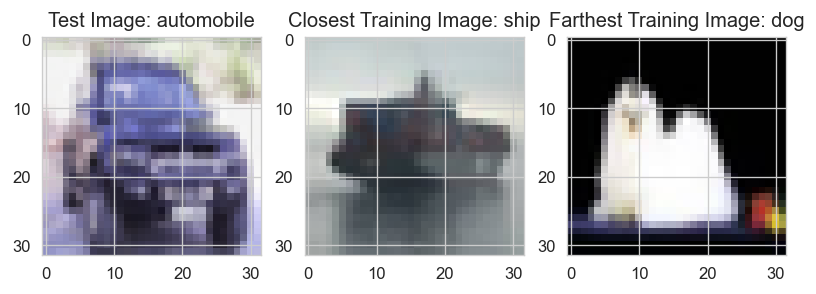

Pred is false 
Test image has true label airplane and predicted label ship


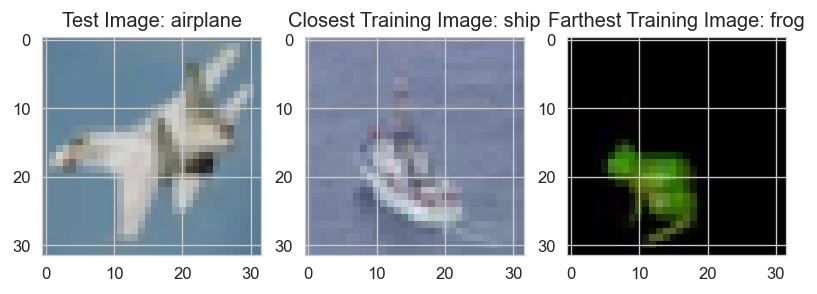

Pred is false 
Test image has true label truck and predicted label ship


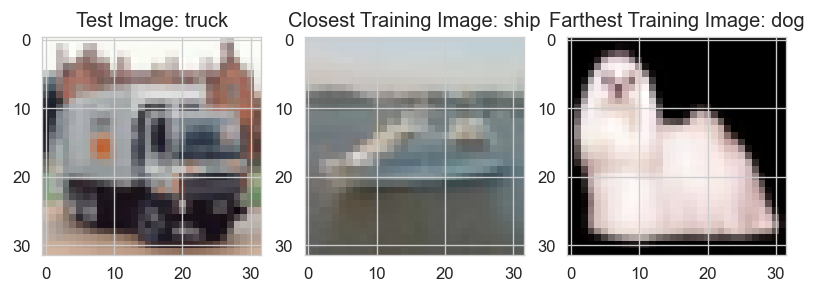

Pred is correct 
Test image has true label dog and predicted label dog


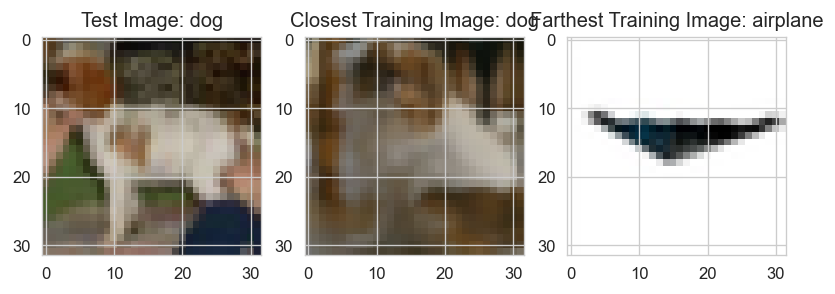

Pred is false 
Test image has true label horse and predicted label frog


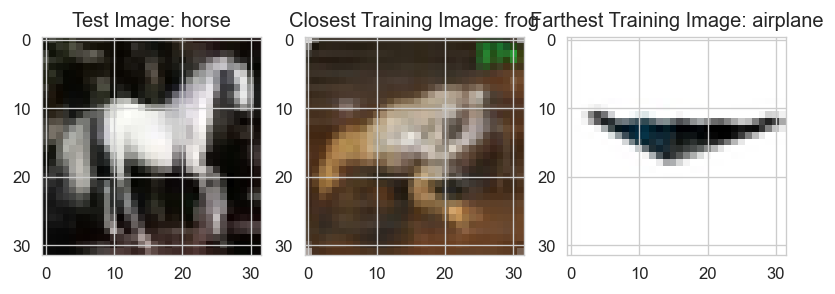

Pred is false 
Test image has true label truck and predicted label deer


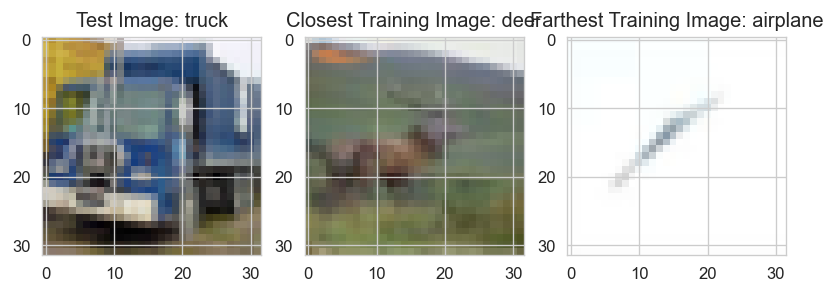

Pred is false 
Test image has true label ship and predicted label deer


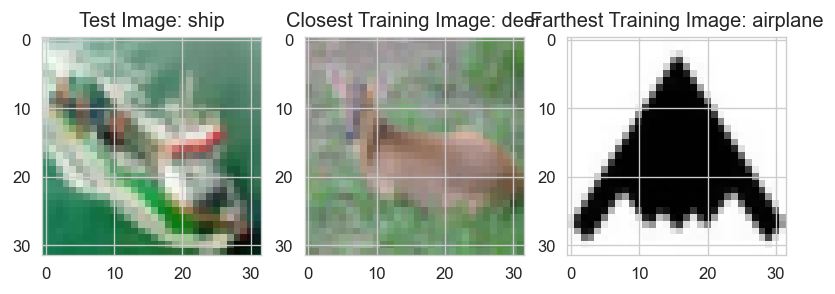

Pred is false 
Test image has true label dog and predicted label cat


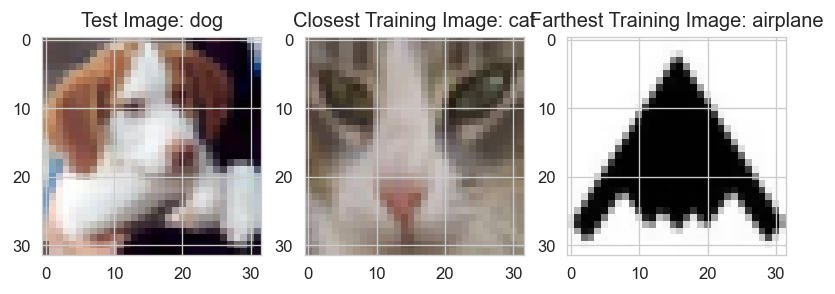

Pred is false 
Test image has true label horse and predicted label cat


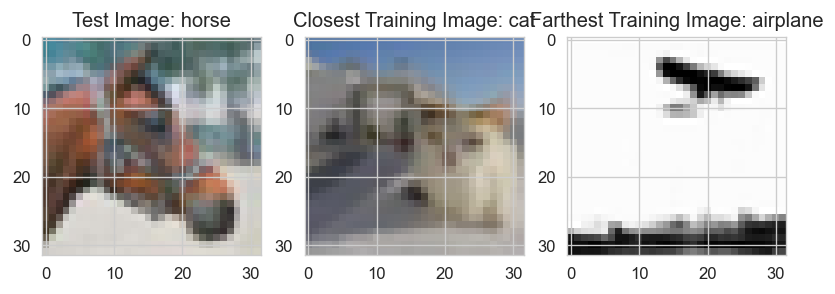

Pred is false 
Test image has true label ship and predicted label automobile


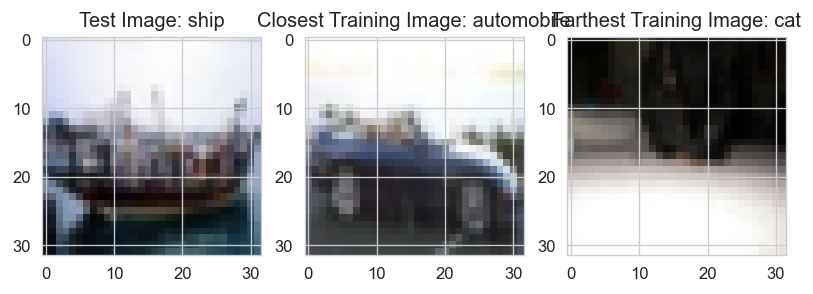

Pred is correct 
Test image has true label frog and predicted label frog


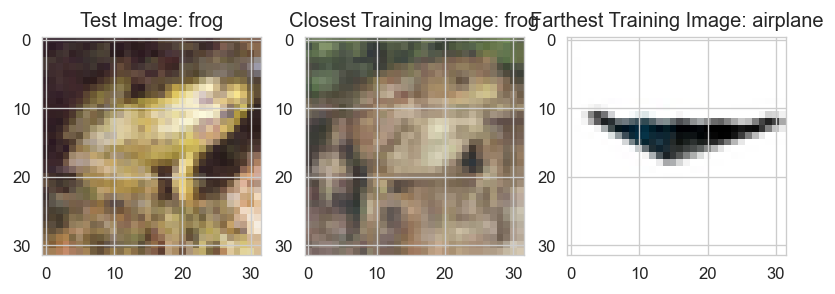

In [51]:
for testi in range(20):
    im = data_te[testi]
    l = labels_te[testi]

    closest_distance = np.inf
    closest_index = -1
    farthest_distance = -np.inf
    farthest_index = -1

    for index, train_im in enumerate(data_tr):
        dist = distance(im, train_im)
        if dist < closest_distance:
            closest_distance = dist
            closest_index = index
        if dist > farthest_distance:
            farthest_distance = dist
            farthest_index = index

    print(
        f"Pred is {"correct" if l == labels_tr[closest_index] else "false"} \n"
        f"Test image has true label {labelnames[l]} and predicted label {labelnames[labels_tr[closest_index]]}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), dpi=120)
    ax1.imshow(vec2im(im))
    ax1.set_title(f"Test Image: {labelnames[l]}")

    ax2.imshow(vec2im(data_tr[closest_index]))
    ax2.set_title(f"Closest Training Image: {labelnames[labels_tr[closest_index]]}")

    ax3.imshow(vec2im(data_tr[farthest_index]))
    ax3.set_title(f"Farthest Training Image: {labelnames[labels_tr[farthest_index]]}")

    plt.show()

### 1.3: Compute the accuracy of your classifier over 100 random testing instances
How does it compare to the accuracy of a baseline classifier that just returns a random class (assuming that the 10 classes are equally distributed)? 

**Extension**: also compute the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [31]:
# %% Let's look for the closest (and farthest) training image to each of the first 20 testing images
y_true = []
y_pred = []
for testi in np.random.randint(len(data_te), size=(100,)):
    imvec = data_te[testi]
    l = labels_te[testi]

    closest_distance = np.inf
    closest_index = -1
    for index, train_im in enumerate(data_tr):
        dist = distance(imvec, train_im)
        if dist < closest_distance:
            closest_distance = dist
            closest_index = index

    y_true.append(l)
    y_pred.append(labels_tr[closest_index])
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f'Accuracy is ={accuracy:.2f}')

Accuracy is =0.40


## Exercise 2: implement and evaluate a feature extraction approach
We are now going to extract a few features for each image (both training and testing). Then, we will train a classifier from the sklearn library on the training data, and evaluate it on testing data.

### 2.1: implement a simple feature extractor
Implement a function that given an image, returns the average value for red, green and blue in that image.

In [100]:
def extract_features(im):
    assert (im.shape[2] == 3)
    red_mean = np.mean(im[:, :, 0])
    green_mean = np.mean(im[:, :, 1])
    blue_mean = np.mean(im[:, :, 2])
    return np.array([red_mean, green_mean, blue_mean])


testim = np.array([
    [[1, 2, 3], [2, 3, 4]],
    [[0, 1, 2], [1, 2, 3]],
])
print("Should return [1 2 3]: ", extract_features(testim))

Should return [1 2 3]:  [1. 2. 3.]


### 2.2: compute features for the whole training set and testing set
Build an array `features_tr` with shape `(50000,3)` containing the features for each training image (one per row).

Build an array `features_te` with shape `(10000,3)` containing the features for each testing image (one per row).

In [101]:
features_tr = []
for vec in data_tr:
    im = vec2im(vec)
    features_tr.append(extract_features(im))
features_tr = np.array(features_tr)

features_te = []
for vec in data_te:
    im = vec2im(vec)
    features_te.append(extract_features(im))
features_te = np.array(features_te)

### 2.3: train a sklearn classifier on the training set, and compute its accuracy on the testing set

You can use any classifier, such as a K-Nearest-Neighbors classifier:

To create:
`clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`

To train:
`clf.fit(features_tr, labels_tr)`

To use it on new images"
`predicted_labels_te = clf.predict(features_te)`

In [118]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(features_tr, labels_tr)

KNeighborsClassifier(n_neighbors=1)

In [125]:
pred = clf.predict(features_te[:20])

accuracy = clf.score(features_te, labels_te)
print(f"Accuracy is {accuracy:.3f}")

Accuracy is 0.177


### 2.4: extensions

- Also compute the confusion matrix.
- Explore how the accuracy changes if we use more than 1 neighbor.
- When using more than one neighbor (try using many, e.g. 21), the classifier can also return *class probabilities*; read the documentation for [`clf.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba).  For each of the first 20 testing images, dispay the testing image and a bar plot of the probability for the 3 most probable classes for that image according to our classifier.

### 2.5: try extracting different/better features, and check how the accuracy changes

Consider the different options proposed below.  For each, compute on the test set the accuracy of the classifier learned from the training set.

- two random numbers (2 features).  Which accuracy do we expect?
- five random numbers (5 features).  Which accuracy do we expect?
- the average brightness of the image -- i.e. the mean value (1 feature)
- the average RGB values in the top half and in the bottom half (6 features)
- the mean value and variance of the image in each of the four quadrants (8 features)
- the mean value and variance of the intensity of the gradient of the image in each of the four quadrants (8 features)
- the concatenation of all above features
- (optional) the Histogram of Oriented Gradients feature descriptor, as computed by the function `skimage.feature.hog(im)`.  [Read more](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py).

## Exercise 3: train a simple feedforward neural network to solve the classification task

The code below defines a classic feedforward NN architecture with many 3072 input neurons, one hidden layer with 100 neurons, and 10 output neurons, used for classification.  Train the network for a few epochs and check its validation accuracy.

What if you increase the number of neurons in the hidden layer?

In [ ]:
##%%
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(100, input_shape=data_tr[0].shape))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation("softmax"))

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
labels_tr_oh = keras.utils.to_categorical(labels_tr, num_classes=10)
labels_te_oh = keras.utils.to_categorical(labels_te, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(data_tr.astype(float) / 255, labels_tr_oh, epochs=100, batch_size=32,
          validation_steps=None,
          validation_data=(data_te.astype(float) / 255, labels_te_oh))

### 3.1
Train the network for a while, then for each of the first 20 testing images, dispay the testing image and a bar plot of the probability for the 3 most probable classes for that image according to our network.

To apply the trained model, use [`Model.predict(...)`](https://keras.io/models/model/)

## Trailer for next week: train a simple feedforward convolutional neural network to solve the classification task

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

images_tr = []
for vec in data_tr:
    images_tr.append(vec2im(vec))
images_tr = np.array(images_tr)

images_te = []
for vec in data_te:
    images_te.append(vec2im(vec))
images_te = np.array(images_te)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=images_tr[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
labels_tr_oh = keras.utils.to_categorical(labels_tr, num_classes=10)
labels_te_oh = keras.utils.to_categorical(labels_te, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(images_tr.astype(float) / 255, labels_tr_oh, epochs=100, batch_size=32,
          validation_steps=None,
          validation_data=(images_te.astype(float) / 255, labels_te_oh))